In [33]:
'''

Basic usage example: https://pytorch-geometric.readthedocs.io/en/2.6.1/get_started/introduction.html

'''

import networkx as nx

import torch
from torch_geometric.data import Data
from torch_geometric import utils

Data(edge_index=[2, 168], x=[37, 3], y=[1])


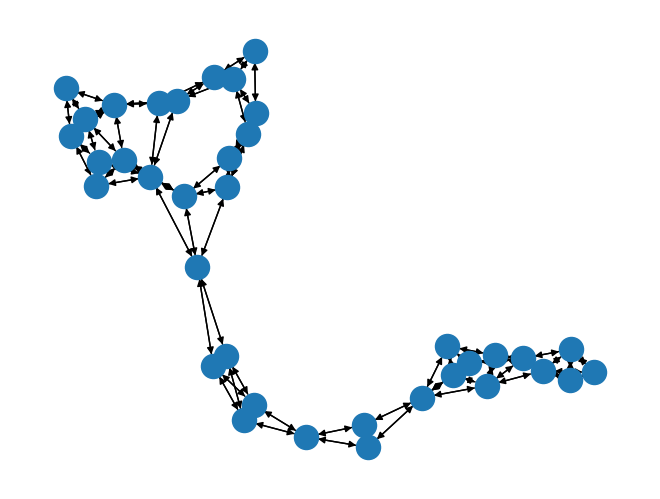

In [34]:
from torch_geometric.datasets import TUDataset

dataset = TUDataset(root='/tmp/ENZYMES', name='ENZYMES')
print(dataset[0])
nx.draw(utils.convert.to_networkx(dataset[0]))


In [15]:
# Batch loader
from torch_geometric.datasets import TUDataset
from torch_geometric.loader import DataLoader

dataset = TUDataset(root='/tmp/ENZYMES', name='ENZYMES', use_node_attr=True)
loader = DataLoader(dataset, batch_size=124, shuffle=True)

for batch in loader:
    print(batch)
    print(batch.num_graphs)


DataBatch(edge_index=[2, 15462], x=[4104, 21], y=[124], batch=[4104], ptr=[125])
124
DataBatch(edge_index=[2, 16054], x=[4260, 21], y=[124], batch=[4260], ptr=[125])
124
DataBatch(edge_index=[2, 15584], x=[4077, 21], y=[124], batch=[4077], ptr=[125])
124
DataBatch(edge_index=[2, 14550], x=[3783, 21], y=[124], batch=[3783], ptr=[125])
124
DataBatch(edge_index=[2, 12914], x=[3356, 21], y=[104], batch=[3356], ptr=[105])
104


In [36]:
'''
Guo lab collective migration dynamics model
'''
import torch
from torch.nn import ModuleList, Linear
import torch.nn.functional as F

import torch_geometric
from torch_geometric.nn import PNAConv, BatchNorm, global_mean_pool
from torch_geometric.utils import degree


# PNA model
def pre_deg(pre_data):
    # Compute in-degree histogram over training data.
    len_deg_safe = 500000  # take a sufficiently large value
    deg_safe = torch.zeros(len_deg_safe, dtype=torch.long)

    for data in pre_data:
        d = degree(data.edge_index[1], num_nodes=data.num_nodes, dtype=torch.long)
        deg_safe += torch.bincount(d, minlength=deg_safe.numel())
    for i in range(len_deg_safe):
        if deg_safe[i:].sum() == 0:
            deg = deg_safe[:i]
            break
    return deg

class myPNA(torch.nn.Module):
    def __init__(self, data_list, in_channels, hidden_channels, num_layers):
        super(myPNA, self).__init__()

        # initialize parameters for PNA
        deg=pre_deg(pre_data=data_list)
        print(deg)
        aggregators = ['sum','mean','std','max','min']
        scalers = ['identity', 'amplification', 'attenuation']

        # initialize module list
        self.convs = ModuleList()
        self.batch_norms = ModuleList()

        # first layer
        conv = PNAConv(in_channels=in_channels, out_channels=hidden_channels,
                       aggregators=aggregators, scalers=scalers, deg=deg,
                       towers=3, pre_layers=1, post_layers=1,
                       divide_input=False)  # channel divided by towel
        self.convs.append(conv)
        self.batch_norms.append(BatchNorm(hidden_channels))

        # hidden layers
        for _ in range(num_layers-1):
            conv = PNAConv(in_channels=hidden_channels, out_channels=hidden_channels,
                           aggregators=aggregators, scalers=scalers, deg=deg,
                           towers=3, pre_layers=1, post_layers=1,
                           divide_input=False)  # channel divided by towel
            self.convs.append(conv)
            self.batch_norms.append(BatchNorm(hidden_channels))
        
        # last linear layer
        self.lin = Linear(hidden_channels, 1)

    def forward(self, x, edge_index, batch):
        for conv, batch_norm in zip(self.convs, self.batch_norms):
            x = conv(x, edge_index)
            x = batch_norm(x)
            x = F.relu(x)

        x = global_mean_pool(x, batch)
        x = self.lin(x)
        return x


In [42]:
import torch
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors


'''
Some visualization functions
'''

# determine the baseline
def getBaseline(data_list_test):
    test_y_values = []
    test_SI_values = []
    # Iterate over the dataset and collect the feature values
    for data in data_list_test:
        test_y_values.append(data.y.item())
        SI = np.median(data.perimeter/np.sqrt(data.area))
        test_SI_values.append(SI)

    # linear fitting
    test_SI_values = np.array(test_SI_values)
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(test_SI_values, test_y_values)
    predicted_y_values = slope * test_SI_values + intercept
    correlation = r_value
    mean_squared_error = np.mean((predicted_y_values - test_y_values) ** 2)

    return correlation, mean_squared_error


# scatter plot mobility against cell density and median shape index
def visualizeDataDistribution(data_list_train, data_list_test):
    train_y_values = []
    train_n0_values = []
    train_SI_values = []
    test_y_values = []
    test_n0_values = []
    test_SI_values = []
    # Iterate over the dataset and collect the feature values
    for data in data_list_train:
        train_y_values.append(data.y.item())
        n0 = torch.tensor(np.array(len(data.x)), dtype=torch.float)
        train_n0_values.append(n0)
        SI = np.median(data.perimeter/np.sqrt(data.area))
        train_SI_values.append(SI)

    for data in data_list_test:
        test_y_values.append(data.y.item())
        n0 = torch.tensor(np.array(len(data.x)), dtype=torch.float)
        test_n0_values.append(n0)
        SI = np.median(data.perimeter/np.sqrt(data.area))
        test_SI_values.append(SI)


    plt.figure(figsize=(6, 3))

    # plot mobility against cell number density
    plt.subplot(121)
    plt.scatter(train_n0_values, train_y_values, s=5, alpha=1.0, c='mediumaquamarine')
    plt.scatter(test_n0_values, test_y_values, s=5, alpha=1.0,c='salmon')

    # linear fit
    test_n0_values = torch.stack(test_n0_values).numpy()
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(test_n0_values, test_y_values)
    predicted_y_values = slope * test_n0_values + intercept
    correlation = r_value
    mean_squared_error = np.mean((predicted_y_values - test_y_values) ** 2)
    plt.plot(test_n0_values, predicted_y_values, color='k', label='Fitted Line')
    print(f'Corr n0 (test) from fitting: {correlation:.4f}, mse n0 (test) from fitting: {mean_squared_error:.4f}')

    plt.xlabel('Cell number, N',fontsize=16)
    plt.ylabel('Mobility, M',fontsize=16)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)

    # shape index dependency plots
    plt.subplot(122)
    plt.scatter(train_SI_values, train_y_values, s=5, alpha=1.0, c='mediumaquamarine')
    plt.scatter(test_SI_values, test_y_values, s=5, alpha=1.0, c='salmon')

    # linear fitting
    test_SI_values = np.array(test_SI_values)
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(test_SI_values, test_y_values)
    predicted_y_values = slope * test_SI_values + intercept
    correlation = r_value
    mean_squared_error = np.mean((predicted_y_values - test_y_values) ** 2)
    plt.plot(test_SI_values, predicted_y_values, color='k', label='Fitted Line')
    print(f'Corr SI (test) from fitting: {correlation:.4f}, mse SI (test) from fitting: {mean_squared_error:.4f}')

    plt.xlabel('$\overline{SI}$',fontsize=16)
    plt.ylabel('Mobility, M',fontsize=16)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)

    plt.tight_layout()
    # plt.show()
    plt.savefig(f'results/DataDistribution.png', dpi=300, bbox_inches='tight')

    # calculate correlation
    corr1, p_value = scipy.stats.pearsonr(np.array(train_n0_values),np.array(train_y_values))
    corr2, p_value = scipy.stats.pearsonr(np.array(train_SI_values),np.array(train_y_values))
    print(f'Corr n0 (train): {corr1:.4f}, Corr SI (train): {corr2:.4f}')

    corr1, p_value = scipy.stats.pearsonr(np.array(test_n0_values),np.array(test_y_values))
    corr2, p_value = scipy.stats.pearsonr(np.array(test_SI_values),np.array(test_y_values))
    print(f'Corr n0 (test): {corr1:.4f}, Corr SI (test): {corr2:.4f}')


# Function to show the Voronoi graphs
def visualizeDataGraph(data_list,ind_lst):
    for i in ind_lst:
        data = data_list[i]
        points= data.cell_pos
        area_lst=data.area
        peri_lst=data.perimeter
        SI_lst = peri_lst / np.sqrt(area_lst)
        voronoi_polygons = data.voronoi_polygons

        fig, ax = plt.subplots()

        edge_index_t=data.edge_index.T
        for edge in edge_index_t:
            plt.plot([points[edge[0], 0], points[edge[1], 0]],
                     [points[edge[0], 1], points[edge[1], 1]],
                     'k:', alpha=0.5)


        # colormap
        norm = mcolors.Normalize(vmin=3.7, vmax=4.5, clip=True)
        mapper = plt.cm.ScalarMappable(norm=norm, cmap=plt.cm.plasma)

        for polygon, SI in zip(voronoi_polygons, SI_lst):
            if polygon is not None:
              x, y = polygon.exterior.xy
              ax.fill(x, y, color=mapper.to_rgba(SI), edgecolor='white')

        plt.colorbar(mapper, ax=ax, orientation='vertical', label='Cell shape index')
        plt.xlabel('X-coordinate')
        plt.ylabel('Y-coordinate')
        ax = plt.gca()
        ax.set_aspect('equal', adjustable='box')
        plt.tight_layout()
        # plt.show()
        plt.savefig(f'results/ExampleInputGraphs{i}.png', dpi=300, bbox_inches='tight')

False
Seeded everything: 12345
Train size:1296, Test size:144


/var/folders/zp/5k1kvm9j0t19cvq8h628kr8h0000gn/T/ipykernel_51447/1665729248.py:117: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  SI_lst = peri_lst / np.sqrt(area_lst)


tensor([   153,    926,   9202,  29391,  65333, 170655, 212024, 112938,  29621,
          4595,    443,     32,      1,      1])


AssertionError: Torch not compiled with CUDA enabled

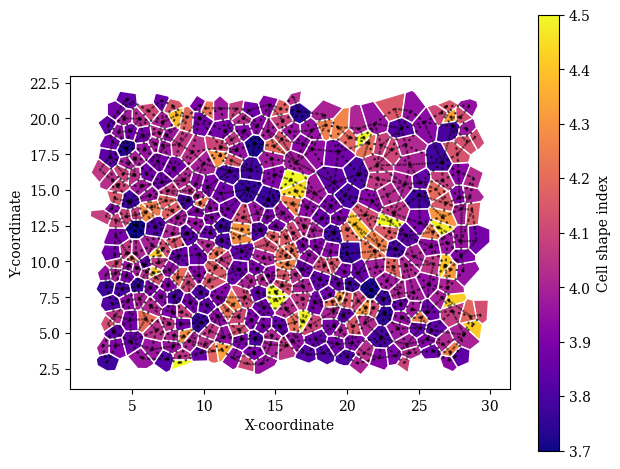

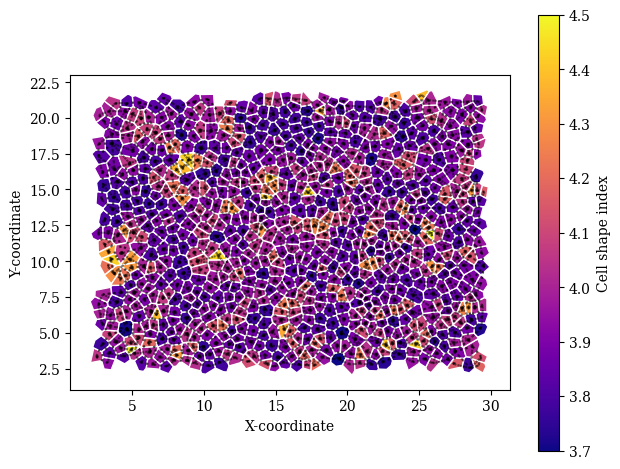

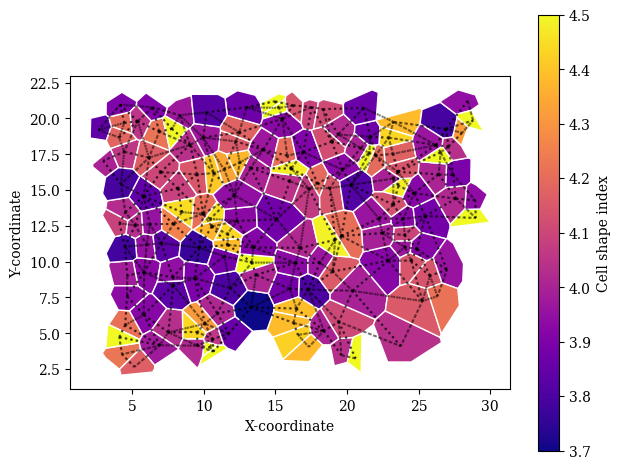

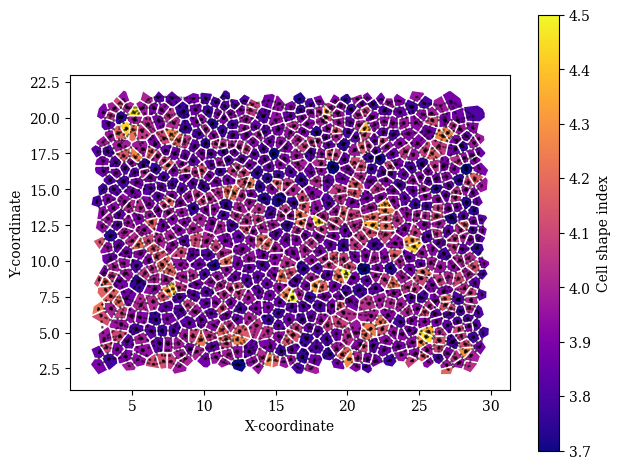

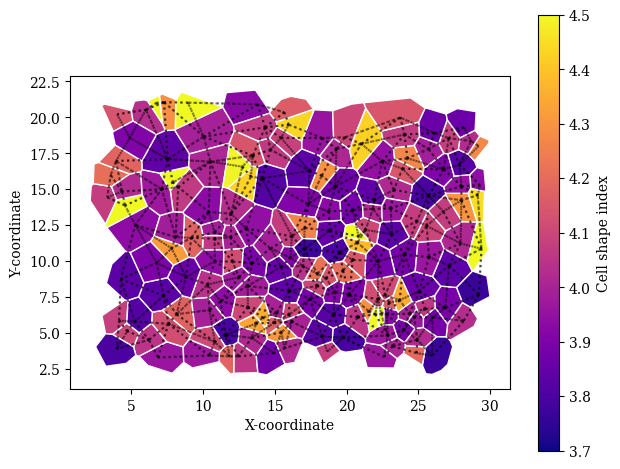

In [44]:
import torch_geometric
from torch_geometric.data import Dataset, Data
# from torch_geometric.data import DataLoader # old
from torch_geometric.loader import DataLoader # updated
import scipy.stats
import seaborn as sns
from scipy import io
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'serif'
print(torch.cuda.is_available())

'''
params
'''
RandSeedNumber = 12345

ablation_type = "Full" # This is the default
# ablation_type = "Positional"
# ablation_type = "Topological"
# ablation_type = "RemoveArea"
# ablation_type = "RemovePeri"
# ablation_type = "RemoveEdgeEntirely"

lagTime         = 3 # ref value: 3. Range: 0 to 6
test_idx_lst    = [16,17]# there are 20 positions in total. By detault, we use 16, 17 as the test set, and the rest as the train set

num_layers      = 5     # ref value: 5
hidden_channels = 36    # ref value: 36
batch_size      = 128   # ref value: 128
learning_rate   = 1e-5  # ref value: 1e-5
weight_decay    = 1e-3  # ref value: 1e-3
EpochNum        = 501   # ref value: 501


'''
Functions
'''
import random
# function for setting random seed number
def set_seed(seed):
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    # torch.use_deterministic_algorithms(True)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    # GPU will be slower but deterministic
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False # True
    print("Seeded everything: {}".format(seed))


# function for loading data
import pickle
def load_dataset(file_name):
    with open(file_name, 'rb') as f:
        data = pickle.load(f)
        return data


# function for picking mean displacement at a given lag time as the output
def setOutput(data_list,lagTime):
    for data in data_list:
            data.y = data.meanDisp[0][lagTime]
    return data_list

# function for choosing the node and edge information as the input
def setInput(data_list, ablation_type):
    for data in data_list:
        
        # assign data.area and data.perimeter
        # this is only for visualization
        data.area = data.x[:,0]
        data.perimeter = data.x[:,1]

        # Assign input
        if ablation_type == "Positional":
            temp = data.cell_pos
            data.x = temp
        elif ablation_type == "Topological":
            temp = torch.zeros_like(data.x)
            data.x = temp
        elif ablation_type == "RemoveArea":
            temp = data.x[:,1]
            temp = temp.unsqueeze(1)
            data.x = temp
        elif ablation_type == "RemovePeri":
            temp = data.x[:,0]
            temp = temp.unsqueeze(1)
            data.x = temp
        elif ablation_type == "RemoveEdgeEntirely":
            # replace edges by self loops
            temp = torch.arange(0, data.x.shape[0], dtype=torch.long).unsqueeze(0).repeat(2, 1)
            data.edge_index = temp
        elif ablation_type == "Full":
            pass
        else:
            raise ValueError("Invalid ablation type")
    return data_list



def train():
    model.train()
    for data in train_loader:
        optimizer.zero_grad()

        # calculate loss
        pred = model(data.x.cuda(), data.edge_index.cuda(), data.batch.cuda())
        loss = criterion(pred.squeeze(), data.y.squeeze().cuda())

        # update
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

    return pred.squeeze().detach().cpu(), data.y.squeeze()


@torch.no_grad()
def test(loader):
    model.eval()
    loss_list=[]
    pred_list=[]
    y_list=[]
    for data in loader:
        pred = model(data.x.cuda(), data.edge_index.cuda(), data.batch.cuda())
        loss = criterion(pred.squeeze().detach().cpu(), data.y.squeeze())
        loss_list.append(loss.item())
        pred_list.extend(pred.squeeze().detach().cpu())
        y_list.extend(data.y.squeeze())
    return loss_list, pred_list, y_list



'''
Main
'''
# create folders for saving results
os.makedirs('results', exist_ok=True)
os.makedirs('weights', exist_ok=True)

# rand seed initialization
set_seed(RandSeedNumber)

# load data
data_list_all = load_dataset('GNNcell_AllExpData.pkl')

# train/test spit
data_list_train = []
data_list_test = []
for i, item in enumerate(data_list_all):
    if i in test_idx_lst:
        data_list_test.extend(item)
    else:
        data_list_train.extend(item)

print(f'Train size:{len(data_list_train)}, Test size:{len(data_list_test)}')

# Select the mean displacement at one lag time scale as the output
data_list_train = setOutput(data_list_train,lagTime)
data_list_test  = setOutput(data_list_test,lagTime)

# Select the node features and edges as the input
data_list_train = setInput(data_list_train, ablation_type)
data_list_test  = setInput(data_list_test, ablation_type)

# Data loader
g = torch.Generator()
g.manual_seed(RandSeedNumber)
train_loader = DataLoader(data_list_train, batch_size=batch_size, shuffle=True, generator=g, drop_last=True)
test_loader = DataLoader(data_list_test, batch_size=4096, shuffle=False, generator=g, drop_last=False) # Here we just use a large enough batch size to load all test data in a single batch

# Some initial visualization
# visualizeDataDistribution(data_list_train, data_list_test)
visualizeDataGraph(data_list_test, np.linspace(0, len(data_list_test)-1, num=5, endpoint=True, dtype=int))


# initialize model
in_channels = data_list_train[0].x.shape[1]
model = myPNA(data_list=data_list_train, in_channels=in_channels, hidden_channels=hidden_channels, num_layers=num_layers).cuda()
print(model)

# initialize optimizer
criterion = torch.nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
use_amp = True
# scaler = torch.cuda.amp.GradScaler(enabled=use_amp)  # old
# scaler = torch.amp.GradScaler('cuda', enabled=use_amp) # updated